In [1]:

# Import the libraries
import networkx as nx
import matplotlib.pyplot as plt
import random
import heapq
from IPython.display import display, clear_output
from PIL import Image
import os


In [5]:
n_nodes = 10
max_cons = 3 #Max conexions of the graph
max_weight = 20
seed = 2 #seed to visualize the graph

x = [i for i in range(n_nodes)]

# Create an empty graph
graph = nx.Graph()

# Add 10 nodes to the graph
for i in range(n_nodes):
  graph.add_node(i)


random_ints = []
# Add edges with random weights
for i in range(n_nodes):
  a = x.copy() #List with nodes excluding current node
  a.pop(i)
  rand_node = [random.choice(a) for j in range(random.randint(1,max_cons))]
  for node in rand_node:
    weight = random.randint(1, max_weight)  # Random weight between 1 and 10
    graph.add_edge(i, node, weight=weight)


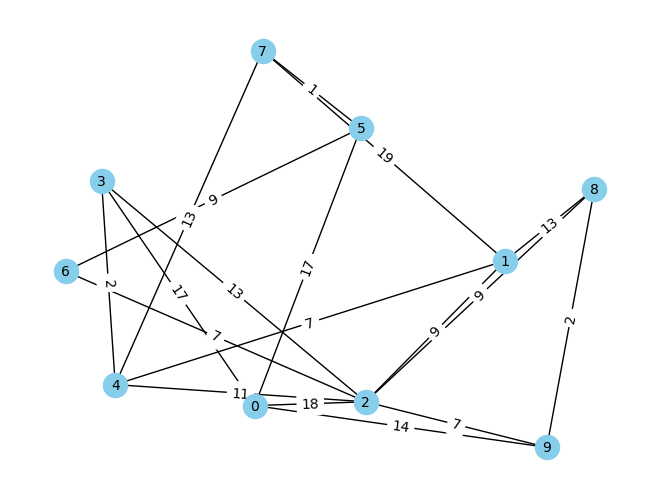

In [6]:
# Draw the graph (optional)
pos = nx.spring_layout(graph, seed=seed, k=5) # positions for all nodes
nx.draw(graph, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=10)
edge_labels = nx.get_edge_attributes(graph,'weight')
nx.draw_networkx_edge_labels(graph,pos,edge_labels=edge_labels)
plt.show()

# Util functions

In [10]:
def calculate_cost(path:list[int], graph:nx.Graph()):
  """Calculates the cost of a path in the graph.

  Args:
      path: A list of ints representing the nodes of the graph.
      graph: The object of the graph

  Returns:
      The total cost of the path
  """
  return sum(graph[path[i]][path[i+1]]['weight'] for i in range(len(path)-1))

def sort_lists(elements:list, indices:list[int]) -> list:
  """Sorts the 'elements' list based on the corresponding indices in the 'indices' list.

  Args:
      elements: A list of elements to be sorted.
      indices: A list of indices corresponding to the elements. Must be the same length as 'elements'.

  Returns:
      A new list with the elements sorted according to the indices.
      Returns None if input lists are invalid.
  """
  if not isinstance(elements, list) or not isinstance(indices, list) or len(elements) != len(indices):
    print("Invalid input: Both 'elements' and 'indices' must be lists of the same length.")
    return None

  return [elements[i] for i in indices]



def get_connected_nodes(graph:nx.Graph(), node_number:int):
  """
  Returns a list of nodes connected to the given node_number in the graph.

  Args:
    node_number: The number of the node.

  Returns:
    A list of node numbers connected to the input node. Returns an empty list if the node is not found or has no connections.
  """
  try:
    connected_nodes = list(graph.neighbors(node_number))
    return connected_nodes
  except KeyError:
    return [] # Return empty list if node not found



def greedy_best_first_search(graph:nx.Graph(), start:int, goal:int):
    """
    Greedy best-first search algorithm.

    Args:
        graph: The graph represented as a NetworkX graph object.
        start: The starting node.
        goal: The goal node.

    Returns:
        A tuple containing:
            - The path from the start node to the goal node.
            - The total cost of the path.
        Returns (None, None) if no path is found.
    """
    visited = set()
    priority_queue = [(0, [start])]  # (estimated_cost, path)

    while priority_queue:
        estimated_cost, path = heapq.heappop(priority_queue)
        current_node = path[-1]

        if current_node == goal:
            return path, sum(graph[path[i]][path[i+1]]['weight'] for i in range(len(path)-1))

        if current_node in visited:
            continue
        visited.add(current_node)

        neighbors = list(graph.neighbors(current_node))
        for neighbor in neighbors:
          if neighbor not in visited:
            new_path = path + [neighbor]
            # Greedy heuristic: use the edge weight as the estimated cost
            heuristic_cost = graph[current_node][neighbor]['weight']
            heapq.heappush(priority_queue, (heuristic_cost, new_path))
    return None, None

# prompt: una función que encuentre un camino desde un nodo a otro de un  grafo de manera aleatoria

def random_path(graph:nx.Graph(), start:int, goal:int):
    """
    Finds a random path from a start node to a goal node in a graph.

    Args:
        graph: The graph represented as a NetworkX graph object.
        start: The starting node.
        goal: The goal node.

    Returns:
        A list representing the random path from the start to the goal node,
        or None if no path is found.
    """
    path = [start]
    visited = {start}
    current = start

    while current != goal:
        neighbors = list(graph.neighbors(current))
        unvisited_neighbors = [n for n in neighbors if n not in visited]

        if not unvisited_neighbors:
            # No unvisited neighbors, backtrack
            if len(path) <= 1 :
              return None # No path found
            path.pop()
            if not path:
                return None
            current = path[-1]
            continue

        next_node = random.choice(unvisited_neighbors)
        path.append(next_node)
        visited.add(next_node)
        current = next_node

    cost = sum(graph[path[i]][path[i+1]]['weight'] for i in range(len(path)-1))
    return path, cost

def visualize_graph(graph:nx.Graph(), path:list[int]=None, seed:int = 2, color:str='red'):
  # Draw the graph with the path highlighted in red
    pos = nx.spring_layout(graph, seed=seed, k=5)
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10)
    edge_labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=edge_labels)
    if path:
      path_edges = list(zip(path,path[1:]))
      nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color=color, width=2)


In [11]:

def dijkstra(graph:nx.Graph(), start:int, goal:int):
    """
    Dijkstra's algorithm to find the shortest path in a graph.

    Args:
        graph: The graph represented as a dictionary where keys are nodes
               and values are dictionaries of neighbors with associated weights.
        start: The starting node.
        goal: The goal node.

    Returns:
        A tuple containing:
            - The shortest path from the start node to the goal node.
            - The total cost of the shortest path.
        Returns (None, None) if no path is found.
    """
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    predecessors = {}
    priority_queue = [(0, start)]

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_distance > distances[current_node]:
            continue

        if current_node == goal:
            path = []
            while current_node is not None:
                path.insert(0, current_node)
                current_node = predecessors.get(current_node)
            return path, distances[goal]

        for neighbor, weight in graph[current_node].items():
            distance = current_distance + weight['weight']
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = current_node
                heapq.heappush(priority_queue, (distance, neighbor))

    return None, None  # No path found

# Evolutionary Aproach

Class and functions for evolutionary aproach

In [13]:
from hashlib import new
#Class for the individuals of the evolutionary algorithm
class GraphEvolution():
  cost:int
  path:list[int]

  def __init__(self, path, cost):
    self.path = path
    self.cost = cost

  def calculate_cost(self, graph):
    path = self.path
    return sum(graph[path[i]][path[i+1]]['weight'] for i in range(len(path)-1))


def crossover(graph:nx.Graph(), path1:list[int], path2:list[int], path_find_func)-> GraphEvolution:
  """
  Generates a new individual by performing a crossover operation on two parent individuals.

    Args:
        graph: The graph represented as a NetworkX graph object.
        path1: path of the first individual.
        path2: path of the second individual.
        path_find_func: A function that finds a path between two nodes in the graph.

    Returns:
        A new GraphEvolution object.
    """

  set1 = set(path1[1:-1])
  set2 = set(path2[1:-1])
  common = list(set1.intersection(set2))
  #If no common nodes return a completely new individual
  if common == []:
    path, cost = path_find_func(graph, path1[0], path1[-1])
    return GraphEvolution(path, cost)

  random_common = random.choice(common)
  common_index_1 = path1.index(random_common)
  common_index_2 = path2.index(random_common)
  new_path = path1
  new_path[common_index_1:] = path2[common_index_2:]
  cost = calculate_cost(graph=graph, path=new_path)

  if new_path[0] != path1[0] or new_path[-1] != path1[-1]:
    print("- - "*15)
    print("CROSSOVER")
    print("NON LEGIT: ")
    print(new_path)

  return GraphEvolution(new_path, cost)


def mutate(graph:nx.Graph(), path:list[int], path_find_func) -> tuple[list[int], float]:
  """
  Changes the path from a random node in the path of the individual.

    Args:
        graph: The graph represented as a NetworkX graph object.
        path: path of the individual.
        path_find_func: A function that finds a path between two nodes in the graph.

    Returns:
        A new GraphEvolution object.
  """

  start_node = path[0]
  end_node = path[-1]

  random_node = random.choice(path[1:-1]) #Choose a node of the path excluding start and end_node
  conected_nodes = get_connected_nodes(graph, random_node) #Get the conected nodes of the random node
  partial_path = path[:path.index(random_node)]
  option_nodes = [x for x in conected_nodes if not x in partial_path]

  if path[0] in conected_nodes: #remove start_node from the posibilities
    conected_nodes.remove(path[0])

  if len(option_nodes) == 0:
    #path, cost = path_find_func(graph, start_node, end_node)
    return path, calculate_cost(graph=graph, path=path)

  new_node = random.choice(option_nodes) #Choose a random node from the conected nodes
  aux_path, aux_cost = path_find_func(graph, new_node, end_node) #Find a path to the end from the new node
  new_path = path.copy()
  new_path[new_path.index(random_node)+1:] = aux_path #Concatenate the path until the node choosed and the new path


  if new_path[0] != path[0] or new_path[-1] != path[-1]:
    print("- - "*15)
    print("NON LEGIT: ")
    print(new_path)

  new_cost = calculate_cost(graph=graph, path=new_path)
  return new_path, new_cost




Derivated functions for evolutionary aproach

In [14]:

def init_pop(pop_size:int, graph:nx.Graph(), start_node:int, end_node:int) -> list[GraphEvolution]:
  """
  #Function to initialize the population with random paths

  Args:
      pop_size: size of the population.
      graph: the nx graph.
      start_node: the number of the start node.
      end_node: the number of the end node.

  Returns:
      A list of GraphEvolution objects.
  """
  population = []
  for i in range(pop_size):
    path, cost = random_path(graph, start_node, end_node)
    population.append(GraphEvolution(path, cost))
  return population


def calculate_top_scores(cost_list:list[float]) -> tuple[list,list]:
  """
  #Function to calcute the top scores in descending order, returns an array with the scores sorted and the original indices

  Args:
      cost_list: list of all the costs of the population

  Returns:
      A tuple of lists, the sorted costs and the original indices of the sorted costs.
  """
  top_scores = []
  indxs = [i for i in range(len(population))]
  for c in cost_list:
    top_scores.append(c)

  indexed_data = list(enumerate(top_scores)) # save in a value,index structure
  # Sort based on the values in the second element of each tuple
  indexed_data.sort(key=lambda x: x[1])
  # Separate sorted values and indices
  sorted_scores = [x[1] for x in indexed_data]
  original_indices = [x[0] for x in indexed_data]

  return sorted_scores, original_indices



def weighted_random_choice(elements:list):
  """
  Chooses a random element from a list, with higher probability for earlier elements.

  Args:
      elements: A list of elements.

  Returns:
      A randomly chosen element from the list.
  """
  # Assign weights inversely proportional to the index (higher weight for earlier elements).
  weights = [1 / (i + 1) for i in range(len(elements))]

  # Normalize weights so they sum to 1.
  total_weight = sum(weights)
  normalized_weights = [w / total_weight for w in weights]

  return random.choices(elements, weights=normalized_weights, k=1)[0]

def sort_population(population:list[GraphEvolution], top_scores_indexs:list):
  sorted_population = sort_lists(population, top_scores_indexs)
  return sorted_population


# Sart evolutionary search

In [30]:
import time
def evolution(population:list[GraphEvolution], max_iterations:int, mutation:float, graph:nx.Graph(), pos:dict) -> list[int]:
  """
  Runs the evolution aproach to find a good path in a graph.

  Args:
      population_list: a list of the initial population.
      max_iterations: number of evolutionary steps.
      mutation: rate to mutate an individual.
      graph: the nx Gaph.
      pos: positions of the nodes to visualize the graph

  Returns:
      A list of numbers representing the best path
  """
  top_scores = []
  top_original_indexes = []

  #output_dir = "frames"
  #os.makedirs(output_dir, exist_ok=True)
  #images = []

  for i in range(max_iterations):
    clear_output(wait=True)

    plt.figure(figsize=(8, 8))

    for k in range(3):
      visualize_grid(grid_graph=graph, pos=pos, path=population[k].path, color='red')

    # save frame
    #frame_path = os.path.join(output_dir, f"frame_{i}.png")
    #plt.savefig(frame_path)
    #plt.close()

    # add frame to then make the GIF
    #images.append(Image.open(frame_path))

    plt.show()
    time.sleep(1)

    for j in range(pop_size):
      current_ind = population[j]
      aux_population = population.copy()

      #Eliminate current individual from list
      aux_population.pop(j)

      #Choice another individual
      rand_ind = weighted_random_choice(aux_population)

      #Create new individual making crossover of two indvs
      new_ind = crossover(graph=graph, path1=current_ind.path.copy(), path2=rand_ind.path.copy(), path_find_func=random_path)

      if random.random() < mutation:
        new_ind.path, new_ind.cost = mutate(path=new_ind.path.copy(), graph=graph, path_find_func=greedy_best_first_search)

      population.append(new_ind)

    original_scores = [x.cost for x in population].copy()
    top_scores, top_original_indexes = calculate_top_scores(original_scores)
    aux_population = sort_population(population.copy(), top_original_indexes)

    population = aux_population[:pop_size]

    print("Population best path and 3 bests scores")
    print(population[0].path)
    print(top_scores[0:3])

  '''
    # Crear el GIF
  gif_path = "graph_animation.gif"
  images[0].save(
      gif_path, save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0
  )
  print(f"GIF creado: {gif_path}")
  '''

  return best_path




# Grid graph

In [21]:

def visualize_grid(grid_graph:nx.grid_2d_graph, pos:dict, path:list[int]=None, color:str='red'):
  """
  Generates the images of a grid graph

  Args:
      grid_graph: nx 2d graph.
      pos: a dict with the positions of the nodes.
      path: (optional) a list of numbers representing a path of nodes of the graph.
      color: (optional) color of the path.
  """
  nx.draw(grid_graph, pos, with_labels=True, node_size=200, node_color="lightblue", font_size=7)
  edge_labels = nx.get_edge_attributes(grid_graph, 'weight')
  nx.draw_networkx_edge_labels(grid_graph, pos, edge_labels=edge_labels)
  if path:
      path_edges = list(zip(path,path[1:]))
      nx.draw_networkx_edges(grid_graph, pos, edgelist=path_edges, edge_color=color, width=2)


def create_grid_graph(rows:int, cols:int)->nx.grid_2d_graph:
  """
  Runs the evolution aproach to find a good path in a graph.

  Args:
      rows: number of rows of the 2d graph.
      cols: number of cols of the 2d graph.

  Returns:
      The nx 2d graph.
  """
  # create 2d graph (like a grid)
  grid_graph = nx.grid_2d_graph(rows, cols)

  # weight of 1 for each edge
  for u, v in grid_graph.edges():
      grid_graph.edges[u, v]['weight'] = 1

  # convert nodes into tuples
  mapping = {node: i for i, node in enumerate(grid_graph.nodes())}
  grid_graph = nx.relabel_nodes(grid_graph, mapping)

  return grid_graph

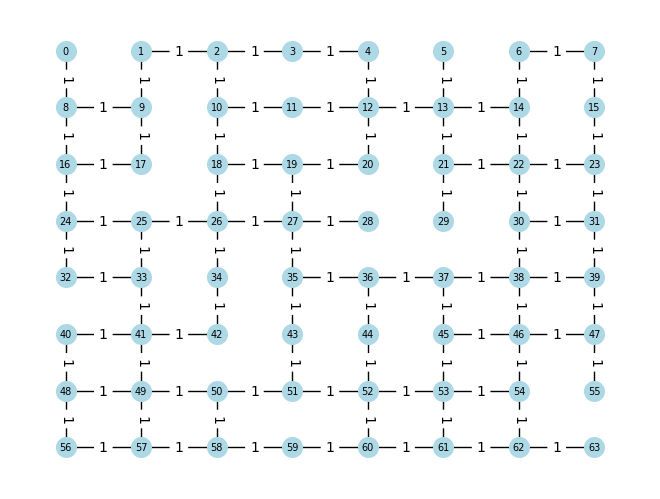

In [22]:
rows = 8
cols = 8
# scale of the graph
scale = 0.5  # select it in less than 1 will bring closer each node

grid = create_grid_graph(rows, cols)
# Generate grid positions
pos = {node: (scale * (node % cols), scale * -(node // cols)) for node in grid.nodes()}

# Simulate obstacles by erasing some random conexions
num_obstacles = 25 # Number of conexions to eliminate
edges = list(grid.edges())
for _ in range(num_obstacles):
    edge_to_remove = random.choice(edges)  # select a random edge to remove
    grid.remove_edge(*edge_to_remove)
    edges.remove(edge_to_remove)

visualize_grid(grid,pos)

# Evolutionary search in grid

In [31]:
start_node = 0
end_node = 63

max_iterations = 5
pop_size = 30
mutation = 0.5
top_size=4

population = []
population = init_pop(pop_size, grid, start_node, end_node)
top_scores, top_original_indexes = calculate_top_scores([x.cost for x in population].copy())
print("Population best path")
print(population[top_original_indexes[0]].path)
print(f"Best 3 scores: {top_scores[0:3]}")

Population best path
[0, 8, 9, 17, 16, 24, 25, 26, 27, 35, 43, 51, 50, 49, 57, 58, 59, 60, 61, 62, 63]
Best 3 scores: [20, 20, 22]


In [34]:
best_path, cost = dijkstra(grid, start_node, end_node)
print("Bestpath by djisktra")
print(best_path)
print(  f"Cost: {cost}")

Bestpath by djisktra
[0, 8, 16, 24, 25, 26, 27, 35, 36, 37, 38, 46, 54, 62, 63]
Cost: 14


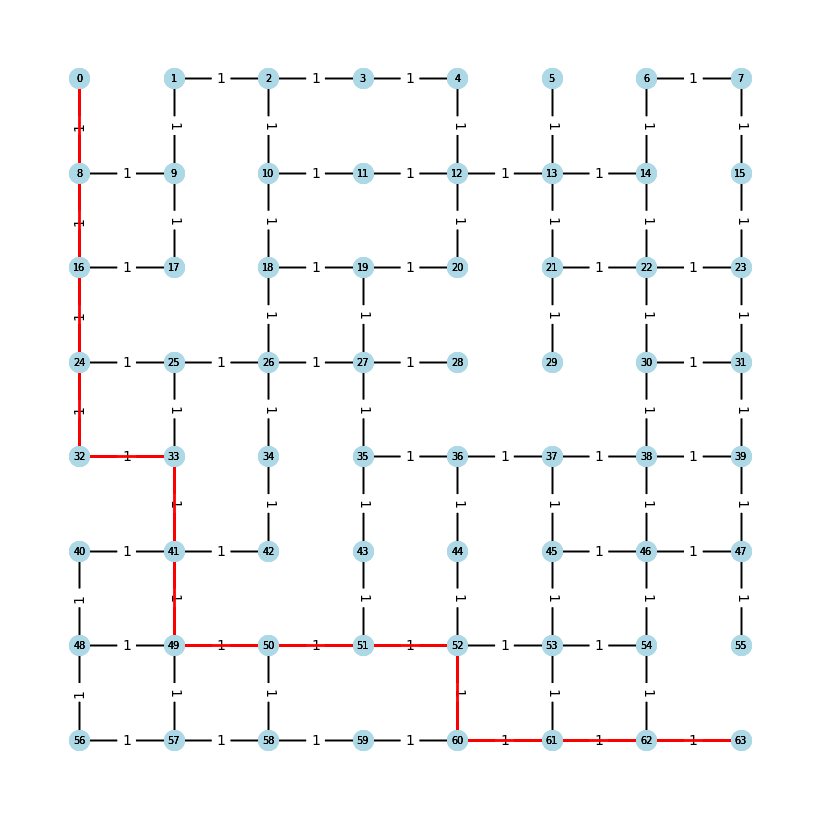

Population best path and 3 bests scores
[0, 8, 16, 24, 32, 33, 41, 49, 50, 51, 52, 60, 61, 62, 63]
[14, 14, 14]


In [36]:
best_path = evolution(population, max_iterations, mutation, grid, pos)